# 1.) Pull in Data and Convert ot Monthly

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from rich import inspect
from icecream import ic

# Elimitate warnings
import warnings
warnings.filterwarnings("ignore")

In [24]:
apple_data = yf.download('AAPL')
ic(apple_data.head());

[*********************100%%**********************]  1 of 1 completed
ic| apple_data.head():                 Open      High       Low     Close  Adj Close     Volume
                       Date                                                                    
                       1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099319  469033600
                       1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094137  175884800
                       1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087228  105728000
                       1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089387   86441600
                       1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091978   73449600


In [25]:
# To revert the order of the data from oldest to newest.
df = apple_data.resample("M").last()[["Adj Close"]]
ic(df.head());
ic(df.index.min());
ic(df.index.max());

ic| df.head():             Adj Close
               Date                 
               1980-12-31   0.117887
               1981-01-31   0.097591
               1981-02-28   0.091546
               1981-03-31   0.084637
               1981-04-30   0.098023
ic| df.index.min(): Timestamp('1980-12-31 00:00:00')
ic| df.index.max(): Timestamp('2024-01-31 00:00:00')


# 2.) Create columns. 
  - Current Stock Price, Difference in stock price, Whether it went up or down over the next month,  option premium

In [26]:
df['delta'] = df["Adj Close"].diff()
df['delta'] = df['delta'].shift(-1)
df = df.dropna()
# sign of the delta
df['target'] = np.where(df['delta'] > 0, 1, -1)
# option premium
df['premium'] = df['Adj Close'] * 0.08
ic(df.head());

ic| df.head():             Adj Close     delta  target   premium
               Date                                             
               1980-12-31   0.117887 -0.020296      -1  0.009431
               1981-01-31   0.097591 -0.006045      -1  0.007807
               1981-02-28   0.091546 -0.006909      -1  0.007324
               1981-03-31   0.084637  0.013386       1  0.006771
               1981-04-30   0.098023  0.016409       1  0.007842


# 3.) Pull in X data, normalize and build a LogReg on column 2

In [27]:
X = pd.read_csv("Xdata.csv", index_col="Date", parse_dates=["Date"])
ic(X.tail());
ic(X.index.min());
ic(X.index.max());
ic(X.describe());

ic| X.tail():                 VAR1
              Date                
              2023-05-31  2.330573
              2023-06-30  3.033257
              2023-07-31  1.007072
              2023-08-31  0.504651
              2023-09-30  0.669328
ic| X.index.min(): Timestamp('1980-12-31 00:00:00')
ic| X.index.max(): Timestamp(

'2023-09-30 00:00:00')
ic| X.describe():              VAR1
                  count  514.000000
                  mean     1.598249
                  std      1.073612
                  min     -0.817647
                  25%      0.609349
                  50%      1.725627
                  75%      2.555558
                  max      3.795485


In [28]:
#y = df.loc[:"2023-09-30","Target"].copy()
min_date = max(X.index.min(), df.index.min())
max_date = min(X.index.max(), df.index.max())
y = df.target.loc[min_date:max_date].copy()
ic(y.tail());
ic(y.index.min());
ic(y.index.max());
ic(y.describe());

ic| y.tail(): Date
              2023-05-31    1
              2023-06-30    1
              2023-07-31   -1
              2023-08-31   -1
              2023-09-30   -1
              Freq: M, Name: target, dtype: int64
ic| y.index.min(): Timestamp('1980-12-31 00:00:00')
ic| y.index.max(): Timestamp('2023-09-30 00:00:00')
ic| y.describe(): count    514.000000
                  mean       0.101167
                  std        0.995839
                  min       -1.000000
                  25%       -1.000000
                  50%        1.000000
                  75%        1.000000
                  max        1.000000
                  Name: target, dtype: float64


In [29]:
scaler = StandardScaler()
X_norm = pd.DataFrame(scaler.fit_transform(X), index=X.index, 
                      columns=X.columns)
X_norm = X_norm.loc[min_date:max_date]
ic(X_norm.head());
ic(X_norm.describe());

ic| X_norm.head():                 VAR1
                   Date                
                   1980-12-31 -1.337900
                   1981-01-31 -1.082263
                   1981-02-28 -1.802444
                   1981-03-31  0.888122
                   1981-04-30  1.466021
ic| X_norm.describe():                VAR1
                       count  5.140000e+02
                       mean   6.220705e-17
                       std    1.000974e+00
                       min   -2.252441e+00
                       25%   -9.219936e-01
                       50%    1.187599e-01
                       75%    8.925395e-01
                       max    2.048576e+00


# 4.) Add columns, prediction and profits.

In [30]:
log_reg = LogisticRegression().fit(X_norm, y)
Y_pred = log_reg.predict(X_norm)
ic(Y_pred[:10]);

ic| Y_pred[:10]: array([-1, -1, -1,  1,  1, -1, -1, -1, -1,  1])


In [31]:
df = df.loc[min_date:max_date]
df['profit'] = 0
# True positive
df.loc[(df['target'] == 1) & (Y_pred == 1), 'profit'] = df['premium']
# False positive
df.loc[(df['target'] == -1) & (Y_pred == 1), 'profit'] = 100*df['delta'] + df['premium']

# 5.) Plot profits over time

<Axes: xlabel='Date'>

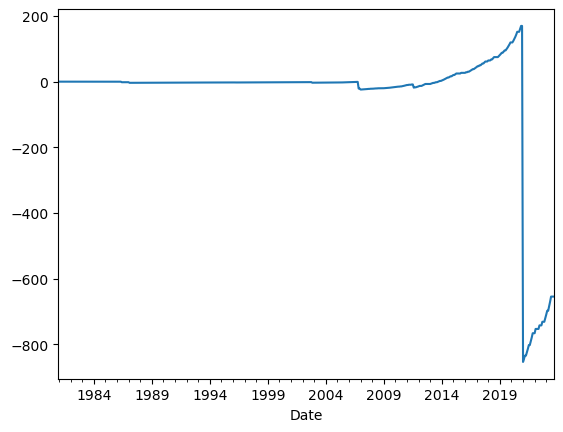

In [32]:
df['profit'].cumsum().plot()
# This could occur because of the pandemic.

# 5.5) Your skills from the MQE to help Mr. Luis.

The speaker specializes in the world of blockchain and cryptocurrency. His initial project involved collaboration with a computer science professor, where they developed a more advanced version aimed at enhancing efficiency beyond Ethereum, named Avalanche.

He could contribute significantly to matters concerning network governance by investigating the impacts of various incentive types on network growth, along with other economic aspects of the network.

Given the growth of his platform "The Arena", the accumulation of data presents an opportunity for me to apply my knowledge in the field.

# 6.) Create a loop that stores total profits over time

# 7.) What is the optimal threshold and plot the total profits for this model.